# Mobile Price Classification using KNN (Best Practices)

**Author:** Student  
**Date:** April 2025  

Notebook ini memuat pipeline lengkap:
1. Load & split data  
2. Hyperparameter tuning dengan Pipeline & GridSearchCV  
3. Evaluasi model  
4. Visualisasi dengan PCA  
5. Prediksi pada file test.csv  
6. Simpan model & scaler  


In [16]:
# 1. Import library yang diperlukan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
import joblib

In [18]:
# Setting untuk reproducibility
np.random.seed(42)
plt.style.use('seaborn-v0_8-whitegrid')

In [19]:
# 2. Load dan explore data
df_train = pd.read_csv('../data/train.csv')
print(f"Dataset shape: {df_train.shape}")
print(f"\nDistribusi kelas target:")
print(df_train['price_range'].value_counts().sort_index())

Dataset shape: (2000, 21)

Distribusi kelas target:
price_range
0    500
1    500
2    500
3    500
Name: count, dtype: int64


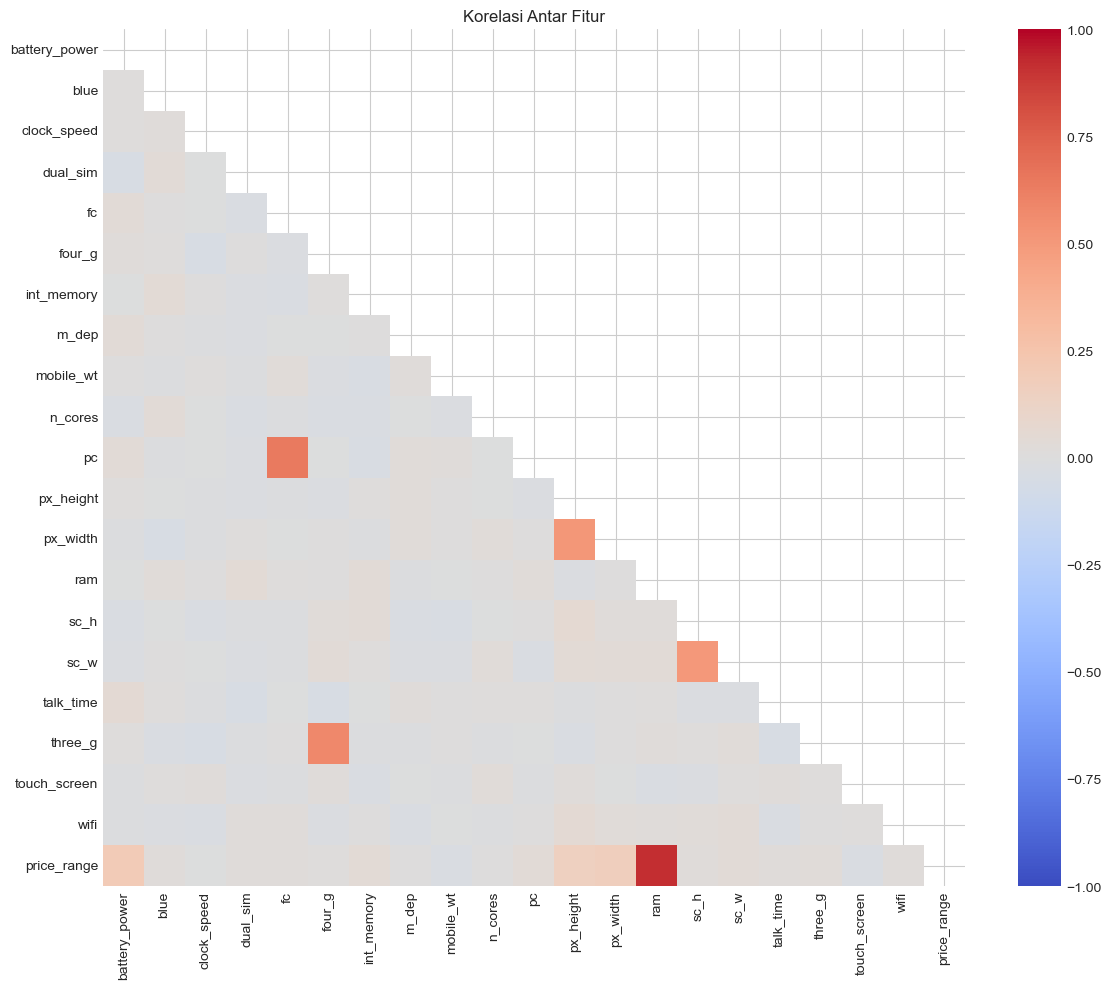

In [21]:
# 3. Analisis korelasi dengan visualisasi yang lebih fokus
plt.figure(figsize=(12, 10))
corr_matrix = df_train.corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', 
            mask=np.triu(corr_matrix), vmin=-1, vmax=1)
plt.title('Korelasi Antar Fitur')
plt.tight_layout()
plt.show()

In [22]:
# Visualisasi korelasi terhadap price_range (lebih informatif untuk KNN)
correlation_with_price = corr_matrix['price_range'].sort_values(ascending=False)
print("\nTop fitur dengan korelasi tertinggi:")
print(correlation_with_price.head(6))


Top fitur dengan korelasi tertinggi:
price_range      1.000000
ram              0.917046
battery_power    0.200723
px_width         0.165818
px_height        0.148858
int_memory       0.044435
Name: price_range, dtype: float64


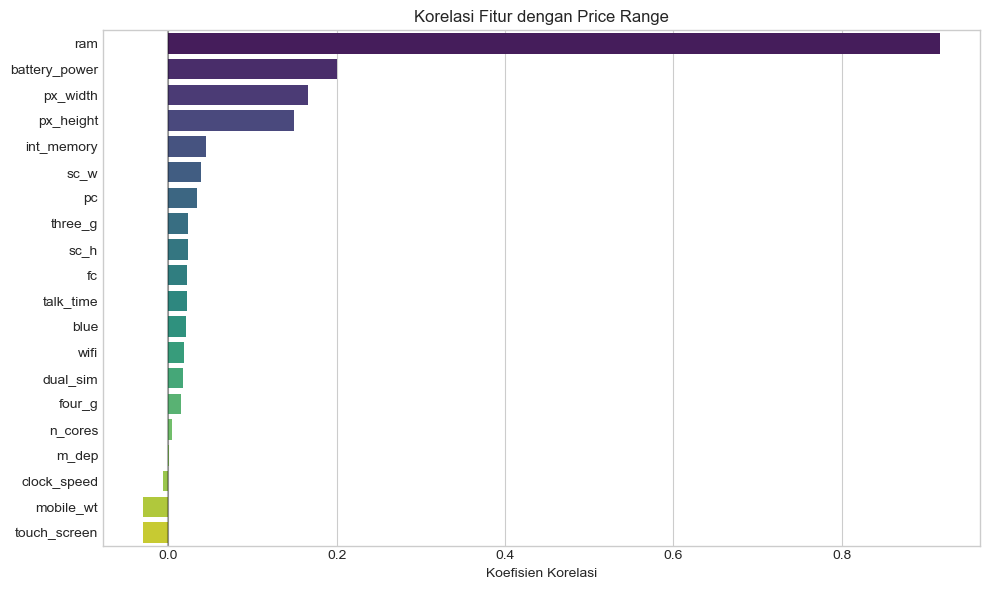

In [23]:
plt.figure(figsize=(10, 6))
top_features = correlation_with_price.drop('price_range')
sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')
plt.title('Korelasi Fitur dengan Price Range')
plt.xlabel('Koefisien Korelasi')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show()

c:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating ins

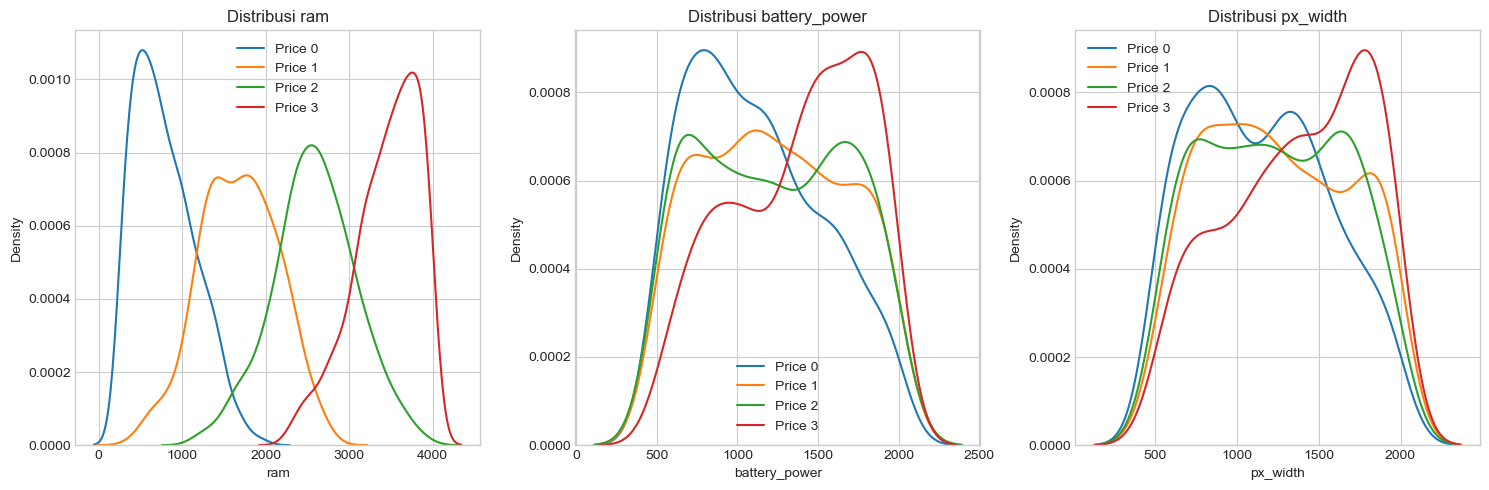

In [24]:
# 4. Visualisasi distribusi fitur terpenting (penting untuk memahami data pada KNN)
top_3_features = correlation_with_price.drop('price_range').nlargest(3).index.tolist()
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, feature in enumerate(top_3_features):
    for price_range in sorted(df_train['price_range'].unique()):
        sns.kdeplot(
            df_train[df_train['price_range'] == price_range][feature],
            ax=axes[i],
            label=f'Price {price_range}'
        )
    axes[i].set_title(f'Distribusi {feature}')
    axes[i].set_xlabel(feature)
    axes[i].legend()

plt.tight_layout()
plt.show()

In [26]:
# 5. Preprocessing Data dengan Standardisasi
X = df_train.drop('price_range', axis=1)
y = df_train['price_range']

# Standardisasi fitur (krusial untuk KNN)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [27]:
# 6. Train-Test Split dengan stratifikasi
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")

Training set size: 1600, Test set size: 400


In [28]:
# 7. Cross-validation untuk estimasi performa dasar
cv_scores = cross_val_score(
    KNeighborsClassifier(n_neighbors=5), 
    X_scaled, y, 
    cv=5, 
    scoring='accuracy'
)
print(f"\nBaseline 5-fold CV accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


Baseline 5-fold CV accuracy: 0.5030 ± 0.0087


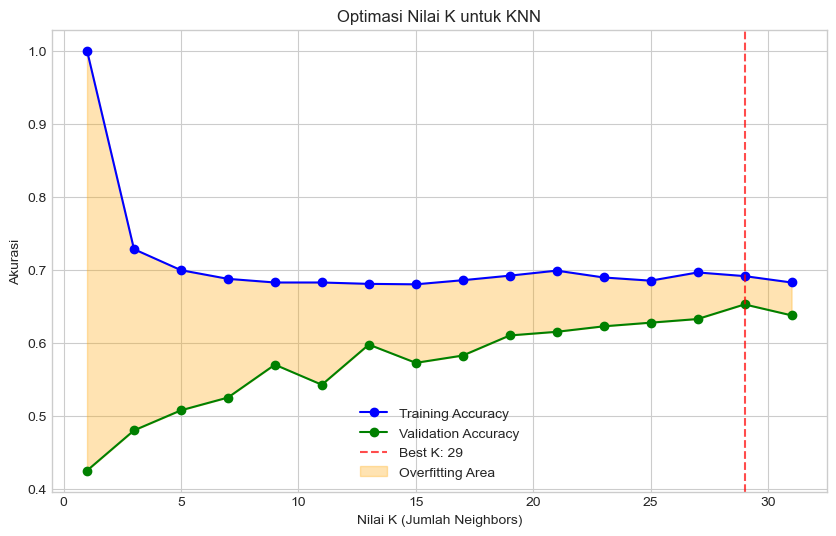

Nilai K optimal: 29
Akurasi validasi tertinggi: 0.6525


In [29]:
# 8. Optimasi nilai K dengan visualisasi akurasi
def find_optimal_k(X_train, y_train, X_test, y_test):
    k_values = list(range(1, 32, 2))  # Nilai K ganjil dari 1 sampai 31
    train_accuracy = []
    test_accuracy = []
    
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        
        train_accuracy.append(knn.score(X_train, y_train))
        test_accuracy.append(knn.score(X_test, y_test))
    
    # Visualisasi
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, train_accuracy, 'o-', color='blue', label='Training Accuracy')
    plt.plot(k_values, test_accuracy, 'o-', color='green', label='Validation Accuracy')
    
    # Menandai K terbaik & area overfitting
    best_k = k_values[test_accuracy.index(max(test_accuracy))]
    plt.axvline(x=best_k, color='red', linestyle='--', alpha=0.7, 
               label=f'Best K: {best_k}')
    
    plt.fill_between(k_values, train_accuracy, test_accuracy, 
                     where=(np.array(train_accuracy) > np.array(test_accuracy)),
                     color='orange', alpha=0.3, label='Overfitting Area')
    
    plt.xlabel('Nilai K (Jumlah Neighbors)')
    plt.ylabel('Akurasi')
    plt.title('Optimasi Nilai K untuk KNN')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return best_k, max(test_accuracy)

best_k, best_acc = find_optimal_k(X_train, y_train, X_test, y_test)
print(f"Nilai K optimal: {best_k}")
print(f"Akurasi validasi tertinggi: {best_acc:.4f}")


In [30]:
# 9. Optimasi Parameter dengan GridSearchCV (simpel namun efektif)
param_grid = {
    'n_neighbors': [best_k-2, best_k, best_k+2],  # Fokus di sekitar K terbaik
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search = GridSearchCV(
    KNeighborsClassifier(), 
    param_grid, 
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print("\nParameter terbaik:")
print(grid_search.best_params_)
print(f"Akurasi CV terbaik: {grid_search.best_score_:.4f}")



Parameter terbaik:
{'metric': 'manhattan', 'n_neighbors': 31, 'weights': 'distance'}
Akurasi CV terbaik: 0.6594


In [ ]:
# 10. Model Final dengan parameter optimal
final_model = KNeighborsClassifier(**grid_search.best_params_)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

In [33]:
# 11. Evaluasi Model dengan visualisasi yang informatif
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAkurasi model final: {accuracy:.4f}")


Akurasi model final: 0.7250


<Figure size 800x600 with 0 Axes>

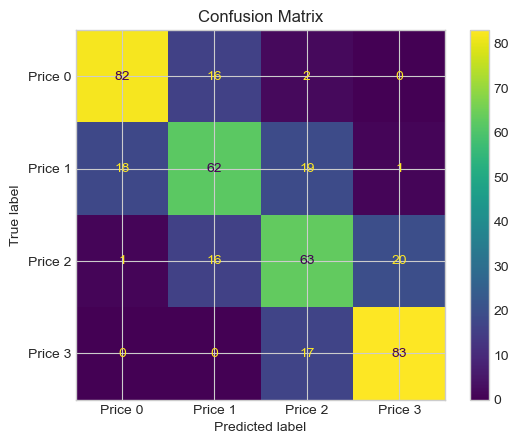

In [34]:
# Visualisasi Confusion Matrix yang lebih informatif
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"Price {i}" for i in range(4)])
disp.plot(cmap='viridis', values_format='d')
plt.title('Confusion Matrix')
plt.show()

In [35]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=[f'Price {i}' for i in range(4)]))



Classification Report:
              precision    recall  f1-score   support

     Price 0       0.81      0.82      0.82       100
     Price 1       0.66      0.62      0.64       100
     Price 2       0.62      0.63      0.63       100
     Price 3       0.80      0.83      0.81       100

    accuracy                           0.73       400
   macro avg       0.72      0.72      0.72       400
weighted avg       0.72      0.72      0.72       400



In [37]:
# 12. Visualisasi hasil KNN dengan PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Informasi variance explained
print(f"\nVariance explained by 2 PCs: {sum(pca.explained_variance_ratio_):.2f}")



Variance explained by 2 PCs: 0.16


<Figure size 1200x1000 with 0 Axes>

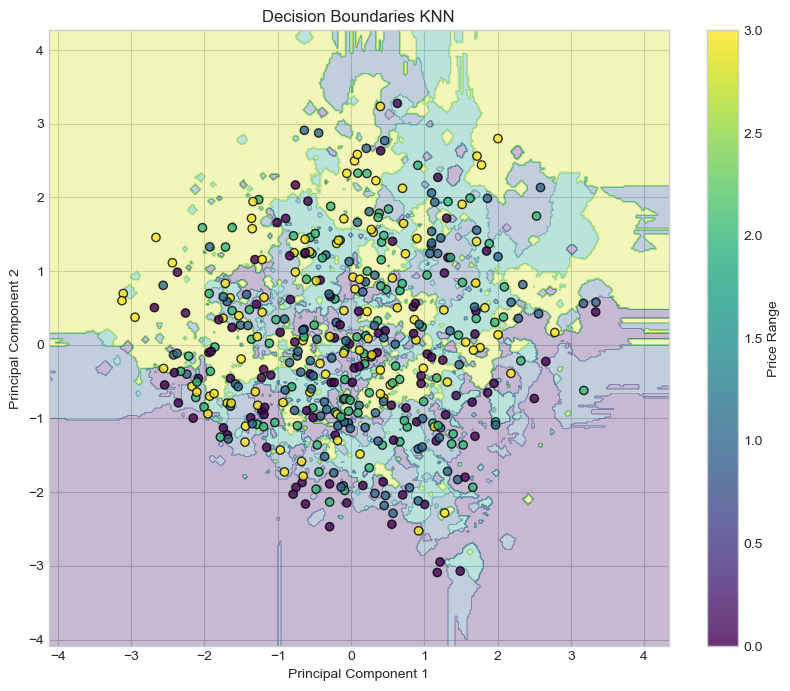

In [38]:
# Membuat mesh grid untuk visualisasi decision boundary
def plot_decision_boundaries(X, y, model, ax=None):
    h = 0.02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    if ax is None:
        plt.figure(figsize=(10, 8))
        ax = plt.gca()
        
    ax.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', 
                        cmap='viridis', alpha=0.8)
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_title('Decision Boundaries KNN')
    return scatter

# Visualisasi decision boundary KNN (khas untuk KNN)
plt.figure(figsize=(12, 10))
pca_model = KNeighborsClassifier(**grid_search.best_params_)
pca_model.fit(X_train_pca, y_train)

scatter = plot_decision_boundaries(X_test_pca, y_test, pca_model)
plt.colorbar(scatter, label='Price Range')
plt.show()

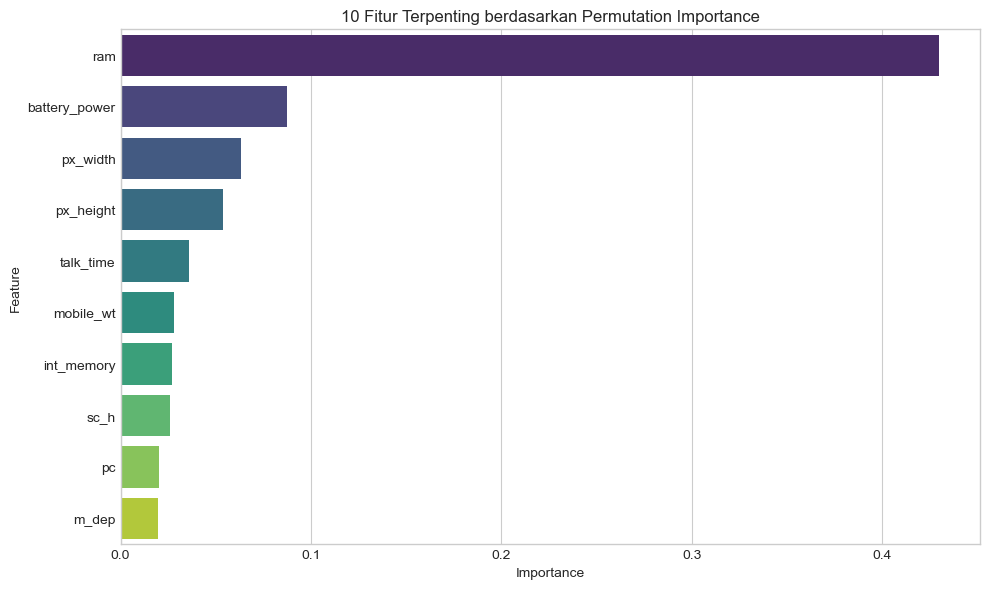


Top 5 fitur berdasarkan permutation importance:
          Feature  Importance
13            ram     0.43000
0   battery_power     0.08750
12       px_width     0.06325
11      px_height     0.05375
16      talk_time     0.03600


In [39]:
# 13. Feature Importance dengan Permutation Importance
# Permutation importance sangat relevan untuk model KNN
result = permutation_importance(
    final_model, X_test, y_test, 
    n_repeats=10, random_state=42, n_jobs=-1
)

# Visualisasi feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': result.importances_mean
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10), palette='viridis')
plt.title('10 Fitur Terpenting berdasarkan Permutation Importance')
plt.tight_layout()
plt.show()

print("\nTop 5 fitur berdasarkan permutation importance:")
print(feature_importance.head(5))

In [41]:
# 14. Prediksi pada dataset testing
df_test = pd.read_csv('../data/test.csv')
X_test_final = df_test.drop('id', axis=1)
X_test_final_scaled = scaler.transform(X_test_final)

test_predictions = final_model.predict(X_test_final_scaled)

# Hasil prediksi
results = pd.DataFrame({
    'id': df_test['id'],
    'predicted_price_range': test_predictions
})

print("\nHasil prediksi pada data testing (5 baris pertama):")
print(results.head())



Hasil prediksi pada data testing (5 baris pertama):
   id  predicted_price_range
0   1                      2
1   2                      2
2   3                      3
3   4                      3
4   5                      1


In [42]:
print("\n" + "="*60)
print("RINGKASAN MODEL KNN UNTUK MOBILE PRICE CLASSIFICATION")
print("="*60)
print(f"• K optimal: {best_k}")
print(f"• Parameter terbaik: {grid_search.best_params_}")
print(f"• Akurasi final: {accuracy:.4f}")
print("\nTop 3 fitur berdasarkan korelasi:")
for feature, corr in correlation_with_price.head(3).items():
    if feature != 'price_range':
        print(f"• {feature}: {corr:.4f}")
print("\nTop 3 fitur berdasarkan permutation importance:")
for _, row in feature_importance.head(3).iterrows():
    print(f"• {row['Feature']}: {row['Importance']:.4f}")
print("="*60)



RINGKASAN MODEL KNN UNTUK MOBILE PRICE CLASSIFICATION
• K optimal: 29
• Parameter terbaik: {'metric': 'manhattan', 'n_neighbors': 31, 'weights': 'distance'}
• Akurasi final: 0.7250

Top 3 fitur berdasarkan korelasi:
• ram: 0.9170
• battery_power: 0.2007

Top 3 fitur berdasarkan permutation importance:
• ram: 0.4300
• battery_power: 0.0875
• px_width: 0.0632
